# Redes Neurais Artificiais 2020.1 -- Projeto Prático 3.4

**Disciplina**: Redes Neurais Artificiais 2020.1  
**Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
**Github**: http://github.com/elloa  
**Aluno(a):** Erik Atilio Silva Rey  
**Aluno(a):** Enrique Leão Barbosa Izel
        

Levando em conta a base de dados **_Forest Cover Type_**, esta terceira parte do Projeto Prático 3 diz respeito à proposição e avaliação de múltiplas redes neurais artificiais do tipo feedforward multilayer perceptron para o problema da classificação multi-classe da cobertura florestal em uma área do Roosevelt National Forest.  

In [ ]:
## Reservado para a importação de bibliotecas
import numpy as np
import pandas as pd
import math
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
import warnings
drive.mount('/content/drive')

warnings.filterwarnings('ignore') # Ignora warnings

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Busca em Grade

Uma maneira padrão de escolher os parâmetros de um modelo de Machine Learning é por meio de uma busca em grade via força bruta. O algoritmo da busca em grade é dado como segue:

1. Escolha a métrica de desempenho que você deseja maximizar  
2. Escolha o algoritmo de Machine Learning (exemplo: redes neurais artificiais). Em seguida, defina os parâmetros ou hiperparâmetros deste tipo de modelo sobre os quais você dseja otimizar (número de épocas, taxa de aprendizado, etc.) e construa um array de valores a serem testados para cada parâmetro ou hiperparâmetro.  
3. Defina a grade de busca, a qual é dada como o produto cartesiano de cada parâmetro a ser testado. Por exemplo, para os arrays [50, 100, 1000] e [10, 15], tem-se que a grade é [(50,10), (50,15), (100,10), (100,15), (1000,10), (1000,15)].
4. Para cada combinação de parâmetros a serem otimizados, utilize o conjunto de treinamento para realizar uma validação cruzada (holdout ou k-fold) e calcule a métrica de avaliação no conjunto de teste (ou conjuntos de teste)
5. Escolha a combinação de parâmetros que maximizam a métrica de avaliação. Este é o modelo otimizado.

Por que esta abordagem funciona? Porque a busca em grade efetua uma pesquisa extensiva sobre as possíveis combinações de valores para cada um dos parâmetros a serem ajustados. Para cada combinação, ela estima a performance do modelo em dados novos. Por fim, o modelo com melhor métrica de desempenho é escolhido. Tem-se então que este modelo é o que melhor pode vir a generalizar mediante dados nunca antes vistos.

## Efetuando a Busca em Grade sobre Hiperparâmetros das Top-6 RNAs

Considerando a etapa anterior do projeto prático, foram identificadas pelo menos 6 melhores Redes Neurais para o problema da classificação multi-classe da cobertura florestal no conjunto de dados selecionado. Algumas destas redes possuem atributos categóricos como variáveis preditoras, enquanto outras possuem apenas os atributos numéricos como preditores.

A primeira etapa desta segunda parte do projeto consiste em trazer para este notebook estas seis arquiteturas, ressaltando:

1. Número de neurônios ocultos por camada  
2. Função de Ativação  
3. Utilização ou não de atributos categóricos   
4. Desempenho médio +- desvio padrão nos testes anteriores  
5. Número de repetições que a equipe conseguiu realizar para verificar os resultados  

Elabore uma busca em grade sobre estas arquiteturas que contemple variações nos hiperparâmetros a seguir, conforme documentação de [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

A. Solver  (Não usar o LBFGS, pois é mais adequado para datasets pequenos)  
B. Batch Size  
C. Learning Rate Init  
D. Paciência (n_iter_no_change)  
E. Épocas  

Nesta busca em grande, contemple a utilização do objeto [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

## Validação Cruzada k-fold

Na elaboração da busca em grid, vamos avaliar os modelos propostos segundo uma estratégia de validação cruzada ainda não explorada até o momento: a validação cruzada k-fold. Segundo a mesma, o conjunto de dados é particionado em k partes: a cada iteração, separa-se uma das partes para teste e o modelo é treinado com as k-1 partes remanescentes. Valores sugestivos de k na literatura são k = 3, 5 ou 10, pois o custo computacional desta validação dos modelos é alto. A métrica de desempenho é resultante da média dos desempenhos nas k iterações. A figura a seguir ilustra a ideia desta avaliação

<img src = "https://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png" width=600></img>

Considerando a métrica de desempenho F1-Score, considere a validação cruzada 5-fold para aferir os resultados da busca em grande anterior.

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/projeto-pratico-3-equipe-ultra-mega-dinamite/notebooks/data/covtype.csv')

In [ ]:
# Função para remover colunas dos atributos categóricos
def remove_columns(column, n):
    columns_to_remove = []
    for i in range(1,n+1):
        columns_to_remove.append(column+str(i))
    return df.drop(columns_to_remove, axis=1)

In [ ]:
df = remove_columns('Soil_Type', 40)
df = remove_columns('Wilderness_Area', 4)
df_y = df['Cover_Type']
df_x = df.loc[:, 'Elevation':'Horizontal_Distance_To_Fire_Points']

In [ ]:
top_6 = []
# Top 3 das 10 arquiteturas configuradas
top_6.append({                                                          
    "camadas": 2,"função_ativação": "identity", "hiperparâmetro": "adam",
    "épocas": 100, "neurônios": 2, "disposição_nêuronios": (1,1), "acurácia": 0.69418,
    "f1score": 0.370575
})
top_6.append({                                                          
    "camadas": 2,"função_ativação": "relu", "hiperparâmetro": "sgd",
    "épocas": 150, "neurônios": 15, "disposição_nêuronios": (1,14), "acurácia": 0.69672,
    "f1score": 0.362405
})
top_6.append({                                                          
    "camadas": 2,"função_ativação": "tanh", "hiperparâmetro": "adam",
    "épocas": 100, "neurônios": 9, "disposição_nêuronios": (7,2), "acurácia": 0.69561,
    "f1score": 0.35513
})

# Top 3 das 30 arquiteturas configuradas
top_6.append({                                                          
    "camadas": 1,"função_ativação": "identity", "hiperparâmetro": "adam",
    "épocas": 200, "neurônios": 8, "disposição_nêuronios": 8, "acurácia": 0.69610,
    "f1score": 0.35166
})
top_6.append({                                                          
    "camadas": 2,"função_ativação": "relu", "hiperparâmetro": "sgd",
    "épocas": 200, "neurônios": 8, "disposição_nêuronios": (3,5), "acurácia": 0.69668,
    "f1score": 0.36268
})
top_6.append({                                                          
    "camadas": 2,"função_ativação": "relu", "hiperparâmetro": "sgd",
    "épocas": 200, "neurônios": 9, "disposição_nêuronios": (7,2), "acurácia": 0.69628,
    "f1score": 0.36321
})
result = pd.DataFrame(top_6)
result.index += 1
result

,camadas,função_ativação,hiperparâmetro,épocas,neurônios,disposição_nêuronios,acurácia,f1score
1,2,identity,adam,100,2,"(1, 1)",0.69418,0.370575
2,2,relu,sgd,150,15,"(1, 14)",0.69672,0.362405
3,2,tanh,adam,100,9,"(7, 2)",0.69561,0.355130
4,1,identity,adam,200,8,8,0.69610,0.351660
5,2,relu,sgd,200,8,"(3, 5)",0.69668,0.362680
6,2,relu,sgd,200,9,"(7, 2)",0.69628,0.363210


In [ ]:
GridSearch = []
parameters = {
    "solver": ["sgd", "adam"],
    "batch_size": [250],
    "learning_rate_init": [0.01, 0.02],
    "n_iter_no_change": [30],
    "max_iter": [100]
}

for i in top_6:
  mpl = MLPClassifier(hidden_layer_sizes=(i["camadas"]),
                      activation=i["função_ativação"],
                      solver=i["hiperparâmetro"],
                      max_iter=i["épocas"], verbose=False)
  clf = GridSearchCV(mpl, parameters)
  clf.fit(df_x, df_y)
  GridSearch.append(clf)

## Identificando a mellhor solução

Como resultado da busca em grande com validação cruzada 5-fold, identifique o modelo otimizado com melhor desempenho para o problema. Apresente claramente este modelo, seus parâmetros, hiperparâmetros otimizados e resultados para cada um dos folds avaliados. Esta é a melhor solução identificada em decorrência deste projeto

In [ ]:
best_score, best_estimator = 0.0, 0

for idx, val in enumerate(GridSearch):
    if (best_score < val.best_score_):
        best_score = val.best_score_
        best_estimator = idx

result = pd.DataFrame([top_6[best_estimator]]) # PARÂMETROS
result.index += 1
result

,camadas,função_ativação,hiperparâmetro,épocas,neurônios,disposição_nêuronios,acurácia,f1score
1,1,identity,adam,200,8,8,0.6961,0.35166


In [ ]:
result = pd.DataFrame([GridSearch[best_estimator].best_params_]) # HIPERPARÂMETROS 
result.index += 1
result

,batch_size,learning_rate_init,max_iter,n_iter_no_change,solver
1,250,0.02,100,30,adam


In [ ]:
kFolds = []
for i in range(5):
    kFolds.append([round(GridSearch[best_estimator].cv_results_["split"+str(i)+"_test_score"][0], 5), 
                   round(GridSearch[best_estimator].cv_results_["split"+str(i)+"_test_score"][1], 5), 
                   round(GridSearch[best_estimator].cv_results_["split"+str(i)+"_test_score"][2], 5), 
                   round(GridSearch[best_estimator].cv_results_["split"+str(i)+"_test_score"][3], 5)])
result = pd.DataFrame(kFolds, columns=["F-Score 1", "F-Score 2", "F-Score 3", "F-Score 4"]) # K-FOLDS
result.index += 1
result

,F-Score 1,F-Score 2,F-Score 3,F-Score 4
1,0.36460,0.60443,0.36460,0.68937
2,0.36460,0.77490,0.36460,0.72381
3,0.36461,0.67314,0.36461,0.67605
4,0.36461,0.68323,0.36461,0.67450
5,0.36461,0.56848,0.36461,0.56455


## Empacotando a solução

Suponha que você deve entregar este classificador ao órgão responsável por administrar o Roosevelt National Park. Para tanto, você deve fazer uma preparação do mesmo para utilização neste cenário. Uma vez que já identificou os melhores parâmetros e hiperparâmetros, o passo remanescente consiste em treinar o modelo com estes valores e todos os dados disponíveis, salvando o conjunto de pesos do modelo ao final para entrega ao cliente. Assim, finalize o projeto prático realizando tais passos.

1. Consulte a documentação a seguir:
https://scikit-learn.org/stable/modules/model_persistence.html  
2. Treine o modelo com todos os dados  
3. Salve o modelo em disco  
4. Construa uma rotina que recupere o modelo em disco  
5. Mostre que a rotina é funcional, fazendo previsões com todos os elementos do dataset e exibindo uma matriz de confusão das mesmas

In [ ]:
# Criando novo modelo otimizado e treinando
mpl = MLPClassifier(hidden_layer_sizes=top_6[best_estimator]["camadas"],
                        activation=top_6[best_estimator]["função_ativação"], 
                        solver=GridSearch[best_estimator].best_params_["solver"], 
                        max_iter=GridSearch[best_estimator].best_params_["max_iter"],
                        batch_size=GridSearch[best_estimator].best_params_["batch_size"],
                        learning_rate_init=GridSearch[best_estimator].best_params_["learning_rate_init"],
                        n_iter_no_change=GridSearch[best_estimator].best_params_["n_iter_no_change"],
                        verbose=False).fit(df_x, df_y)

In [ ]:
# Salvando o modelo em disco
dump(mpl, 'MLPClassifier.joblib')

['MLPClassifier.joblib']

In [ ]:
# Carregando o modelo salvo
model = load('MLPClassifier.joblib') 

# Prevendo para todos os exemplos do dataset
y_test = model.predict(df_x)

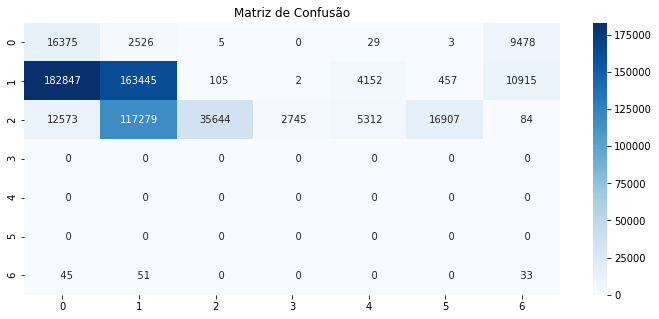

In [ ]:
# Matriz de confusão dos atributos
plt.figure(figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, df_y), annot=True, fmt='5', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()